In [33]:
import os
import zipfile
from google.colab import files


if not os.path.exists('sign_mnist'):
  # Install Kaggle CLI
  !pip install -q kaggle

  # Import your kaggle.json API Key
  files.upload()

  # Moves kaggle.json to the correct location
  !mkdir -p ~/.kaggle
  !mv kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

  # Download Sign Language MNIST dataset
  !kaggle datasets download -d datamunge/sign-language-mnist

  # Extract the dataset
  dataset_zip = 'sign-language-mnist.zip'
  with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
      zip_ref.extractall('sign_mnist')

  # Check extracted files
  os.listdir('sign_mnist')


In [34]:
import cv2 as cv
import numpy as np
# Function to augment images by rotating them 360 degrees in steps of 10 degrees
def augment_with_rotation(images, labels, angles = np.arange(22.5, 360, 22.5) ):
    augmented_images = list(images)  # Start with original images
    augmented_labels = list(labels)  # Start with original labels
    print(angles)


    for img, label in zip(images, labels):
        # Ensure image is in uint8 format
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)

        # Ensure image is 2D
        if len(img.shape) != 2:
            raise ValueError(f"Expected a 2D image, but got shape: {img.shape}")

        rows, cols = img.shape

        for angle in angles:
            # Compute rotation matrix
            M = cv.getRotationMatrix2D(((cols - 1) / 2.0, (rows - 1) / 2.0), angle, 1)
            rotated_img = cv.warpAffine(img, M, (cols, rows))

            augmented_images.append(rotated_img)
            augmented_labels.append(label)  # Keep the same label for rotated images

    return np.array(augmented_images), np.array(augmented_labels)


[ 22.5  45.   67.5  90.  112.5 135.  157.5 180.  202.5 225.  247.5 270.
 292.5 315.  337.5]
[ 22.5  45.   67.5  90.  112.5 135.  157.5 180.  202.5 225.  247.5 270.
 292.5 315.  337.5]
[ 22.5  45.   67.5  90.  112.5 135.  157.5 180.  202.5 225.  247.5 270.
 292.5 315.  337.5]


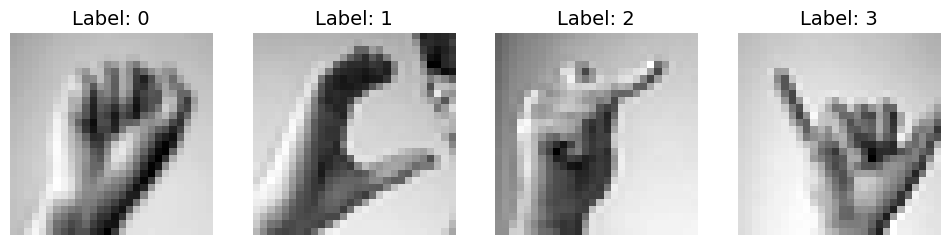

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# To make our gesture recognition more robust, we will restrict
# our number of classes to hand gestures with very distinct profiles.

filtered_labels = [0, 2, 19, 24]


# Filter the datasets
train_df = pd.read_csv('sign_mnist/sign_mnist_train.csv')
train_df = train_df[train_df['label'].isin(filtered_labels)]

test_df = pd.read_csv('sign_mnist/sign_mnist_test.csv')
test_df = test_df[test_df['label'].isin(filtered_labels)]

training_labels = train_df['label'].values
training_images = train_df.drop('label', axis=1).values

testing_labels = test_df['label'].values
testing_images = test_df.drop('label', axis=1).values


# Split the data into images and labels
# Split training data into training (80%) and validation (20%)
training_images, val_images, training_labels, val_labels = train_test_split(
    training_images, training_labels, test_size=0.2, random_state=42, stratify=training_labels
)

# Create a mapping from original labels to new labels
# This will convert the labels to 0,1,2,3
label_mapping = {label: idx for idx, label in enumerate(filtered_labels)}

# Apply the mapping
training_labels = np.vectorize(label_mapping.get)(training_labels)
testing_labels = np.vectorize(label_mapping.get)(testing_labels)
val_labels = np.vectorize(label_mapping.get)(val_labels)

# Reshape the images to 28x28
training_images = training_images.reshape(-1, 28, 28)
testing_images = testing_images.reshape(-1, 28, 28)
val_images = val_images.reshape(-1, 28, 28)

# Augment the data with rotated versions of every image
training_images, training_labels = augment_with_rotation(training_images, training_labels)
testing_images, testing_labels = augment_with_rotation(testing_images, testing_labels)
val_images, val_labels = augment_with_rotation(val_images, val_labels)


# Display an example of each label
selected_images = []
selected_labels = []

for class_label in [0,1,2,3]:
    idx = np.where(training_labels == class_label)[0][0]  # First occurrence
    selected_images.append(training_images[idx])
    selected_labels.append(class_label)

plt.figure(figsize=(len(selected_images) * 3, 3))
for i, (img, lbl) in enumerate(zip(selected_images, selected_labels)):
    plt.subplot(1, len(selected_images), i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Label: {lbl}', fontsize=14)
    plt.axis('off')


plt.show()


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms

# Preprocessing


# Normalize images to [0, 1]
training_images = training_images.astype(np.float32) / 255.0
testing_images = testing_images.astype(np.float32) / 255.0
val_images = val_images.astype(np.float32) / 255.0

# Ensure images have shape (batch_size, 1, 28, 28)
training_images = torch.tensor(training_images).unsqueeze(1)  # Add channel dimension
testing_images = torch.tensor(testing_images).unsqueeze(1)  # Add channel dimension
val_images = torch.tensor(val_images).unsqueeze(1)  # Add channel dimension


training_labels = torch.tensor(training_labels, dtype=torch.long)
testing_labels = torch.tensor(testing_labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)


print("Training images shape:", training_images.shape)  # Should be (num_samples, 1, 28, 28)
print("Testing images shape:", testing_images.shape)  # Should be (num_samples, 1, 28, 28)



Training images shape: torch.Size([58544, 1, 28, 28])
Testing images shape: torch.Size([19536, 1, 28, 28])


In [37]:
# Credit for model goes to https://peyrone.medium.com/comparing-svm-and-cnn-in-recognizing-handwritten-digits-an-overview-5ef06b20194e

import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # First convolution layer: input channels = 1 (grayscale), output = 32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  # 28x28 -> 28x28
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 28x28 -> 14x14
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 14x14 -> 14x14
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)  # 14x14 -> 14x14
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 14x14 -> 7x7

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 64)  # Input size = (64 * 7 * 7)
        self.fc2 = nn.Linear(64, 4)  # Output layer with 4 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> MaxPool (28x28 -> 14x14)
        x = F.relu(self.conv2(x))  # Conv2 -> ReLU (14x14 -> 14x14)
        x = self.pool2(F.relu(self.conv3(x)))  # Conv3 -> ReLU -> MaxPool (14x14 -> 7x7)
        x = x.view(-1, 64 * 7 * 7)  # Flatten (7x7 feature map to vector)
        x = F.relu(self.fc1(x))  # Fully connected layer
        x = self.fc2(x)  # Output layer
        return x

# Create model
model = CNNModel()



In [38]:
import torch.optim as optim
import torch.nn as nn

# Define the optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the loss function (Sparse Categorical Crossentropy)
criterion = nn.CrossEntropyLoss()

# Metrics function for accuracy (can be computed manually during training)
def compute_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy


In [39]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Convert the training and testing data to PyTorch tensors
train_tensor = TensorDataset(torch.tensor(training_images, dtype=torch.float32), torch.tensor(training_labels, dtype=torch.long))
test_tensor = TensorDataset(torch.tensor(testing_images, dtype=torch.float32), torch.tensor(testing_labels, dtype=torch.long))
val_tensor = TensorDataset(torch.tensor(val_images, dtype=torch.float32), torch.tensor(val_labels, dtype=torch.long))
# Create DataLoader for batching
train_loader = DataLoader(train_tensor, batch_size=128, shuffle=True)
test_loader = DataLoader(test_tensor, batch_size=128, shuffle=False)
val_loader = DataLoader(val_tensor, batch_size=128, shuffle=False)

# Define optimizer and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

best_val_loss = float('inf')
early_stop_patience = 5  # Stop if no improvement for 5 epochs
epochs_without_improvement = 0

num_epochs = 50  # Max limit

# Note to self: change this to stop training at epoch 7,
# its overfitting past that -ADB

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Evaluate on validation set
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

    # Reduce LR if validation loss plateaus
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "rotated_gesture_model.pth")  # Save best model
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stop_patience:
            print("Early stopping triggered.")
            break  # Stop training

<ipython-input-39-51867615eff3>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_tensor = TensorDataset(torch.tensor(training_images, dtype=torch.float32), torch.tensor(training_labels, dtype=torch.long))
<ipython-input-39-51867615eff3>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_tensor = TensorDataset(torch.tensor(testing_images, dtype=torch.float32), torch.tensor(testing_labels, dtype=torch.long))
<ipython-input-39-51867615eff3>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_tensor = TensorDataset(torch.tensor(val_

Epoch 1: Train Loss = 0.5069, Val Loss = 0.0790, Val Acc = 0.9747
Epoch 2: Train Loss = 0.0449, Val Loss = 0.0212, Val Acc = 0.9930
Epoch 3: Train Loss = 0.0148, Val Loss = 0.0116, Val Acc = 0.9960
Epoch 4: Train Loss = 0.0072, Val Loss = 0.0042, Val Acc = 0.9991
Epoch 5: Train Loss = 0.0043, Val Loss = 0.0046, Val Acc = 0.9988
Epoch 6: Train Loss = 0.0041, Val Loss = 0.0259, Val Acc = 0.9910
Epoch 7: Train Loss = 0.0052, Val Loss = 0.0010, Val Acc = 0.9999
Epoch 8: Train Loss = 0.0003, Val Loss = 0.0003, Val Acc = 1.0000
Epoch 9: Train Loss = 0.0001, Val Loss = 0.0002, Val Acc = 1.0000
Epoch 10: Train Loss = 0.0000, Val Loss = 0.0001, Val Acc = 1.0000
Epoch 11: Train Loss = 0.0000, Val Loss = 0.0001, Val Acc = 1.0000
Epoch 12: Train Loss = 0.0000, Val Loss = 0.0001, Val Acc = 1.0000
Epoch 13: Train Loss = 0.0000, Val Loss = 0.0001, Val Acc = 1.0000
Epoch 14: Train Loss = 0.0000, Val Loss = 0.0001, Val Acc = 1.0000
Epoch 15: Train Loss = 0.0000, Val Loss = 0.0000, Val Acc = 1.0000
Epoc

KeyboardInterrupt: 

In [ ]:
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation for efficiency
    for inputs, labels in test_loader:
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        test_loss += loss.item()  # Accumulate loss

        # Compute accuracy
        _, predicted = torch.max(outputs, 1)  # Get class with highest probability
        correct += (predicted == labels).sum().item()  # Count correct predictions
        total += labels.size(0)  # Total number of samples

# Compute average loss and accuracy
test_loss /= len(test_loader)
test_acc = correct / total

print(f'\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

In [ ]:

torch.save(model.state_dict(), 'rotated_gesture_model.pth')